<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Чтение данных</a></span></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Основные шаги:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

### Чтение данных

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Датасет состоит из 2 колонок и 26496 строк. Колонка `datetime` имеет тип данных object, колонка `num_orders` тип данных int64.

- **datetime** - значение даты и времени на временной оси;
- **num_orders** - количество заказов.

### Обработка данных

Изменим тип данных datetime с object на datetime64

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
data.dtypes

datetime      datetime64[ns]
num_orders             int64
dtype: object

Проверим таблицу на дубликаты

In [7]:
data[data.duplicated() == True]

,datetime,num_orders


Установим индекс таблицы равным столбцу datetime

In [8]:
df = data.set_index('datetime')

Проверим, в хронологическом ли порядке расположены даты и время. Если порядок соблюдён, атрибут вернёт True.

In [9]:
df.index.is_monotonic

True

Проведем ресемплирование по одному часу. В качестве агрегированного значения ряда выберем сумму, так как нам нужно спрогнозировать количество заказов в следующий час.

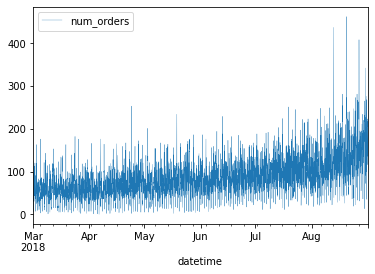

In [10]:
df = df.resample('1H').sum()
df.plot(linewidth=0.3);

## Анализ

Проверим количество пропусков

In [11]:
df.isna().mean().sort_values(ascending=False)

num_orders    0.0
dtype: float64

Проведем анализ временного ряда на тренды и сезонность

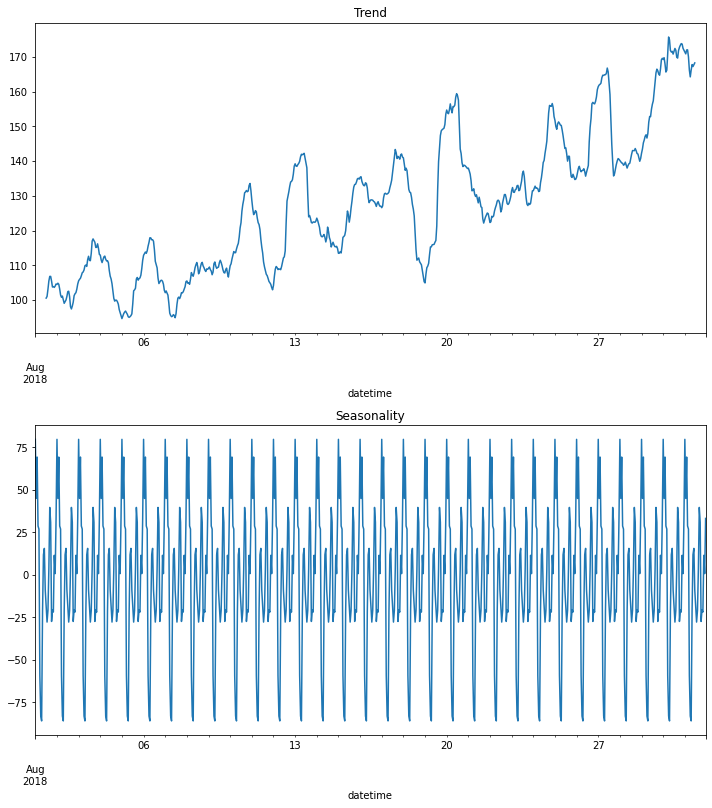

In [12]:
decompose = seasonal_decompose(df['2018-08':'2018-08'])

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Тренд показывает линейный рост спроса на такси. Распределение сезонной части выглядит статичным. Рассмотрим сезонность в разрезе одних суток.

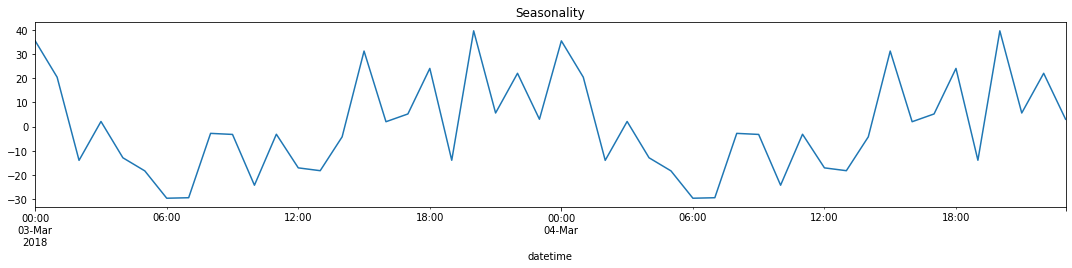

In [13]:
t = df['2018-03-03':'2018-03-04']
decompose = seasonal_decompose(t)
plt.figure(figsize=(15, 10))

plt.subplot(311)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Мы наблюдаем повышенный спрос на такси в период с 15:00 до 00:00 и падение спроса в утренние часы.

Рассмотрим гистограмму

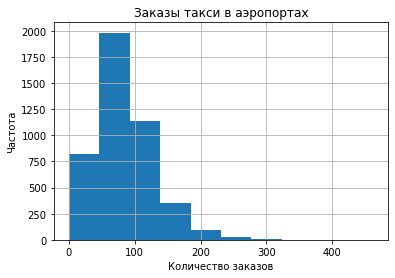

In [14]:
df['num_orders'].hist().set(title='Заказы такси в аэропортах', xlabel='Количество заказов', ylabel='Частота');

Мы видим график с некоторым количеством аномально больших значений. Заменим значения равные или выше девяносто пятого процентиля на предыдущее.

In [15]:
for i in range(len(df)):
    q = df['num_orders'].quantile(0.95)
    if df['num_orders'][i] >= q:
        df.iloc[i] = df.iloc[i-1]   

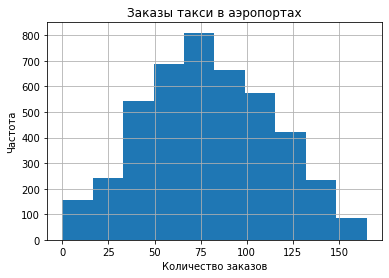

In [16]:
df['num_orders'].hist().set(title='Заказы такси в аэропортах', xlabel='Количество заказов', ylabel='Частота');

Ситуация улучшилась, мы видим нормальное распределение.

## Обучение

Напием функцию make_features(), чтобы прибавить к таблице четыре новых календарных признака (год, месяц, день и день недели), 
вычислить отстающие значения, вычислить скользящее среднее.

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [18]:
make_features(df, 5, 5)

In [22]:
df.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN


Разбьем датасет на обучающую и тестовую выборки. Тестовая выборка равна 10% от исходных данных.

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
train_x = train.drop('num_orders', axis=1)
train_y = train['num_orders']

In [21]:
test_x = test.drop('num_orders', axis=1)
test_y = test['num_orders']

- **CatBoost**

In [ ]:
model_cat = CatBoostRegressor(random_seed=12345)

In [ ]:
parameters_cat = {
    'iterations': [300, 750],
    'depth': [6, 10]
}

.Выберем дефолтное значение n_splits=5

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
cat_gbm =  GridSearchCV(model_cat,parameters_cat, cv=tscv, scoring='neg_root_mean_squared_error',verbose=10, n_jobs=-1)

In [ ]:
cat_gbm.fit(train_x, train_y)

In [ ]:
prediction_cat = cat_gbm.predict(train_x)

In [ ]:
sqrt(mean_squared_error(train_y, prediction_cat)) 

In [ ]:
cat_gbm.best_score_

- **LightGBM**

In [ ]:
model_lgbm = LGBMRegressor(random_state=12345)

In [ ]:
parameters = {
    'max_depth' : [2, 5, 10],
    'num_leaves' : [50, 60]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
gs_gbm = GridSearchCV(model_lgbm,parameters, cv=tscv, scoring='neg_root_mean_squared_error', verbose=10, n_jobs=-1)

In [ ]:
gs_gbm.fit(train_x, train_y)

In [ ]:
prediction_lgbm = gs_gbm.predict(train_x)

In [ ]:
sqrt(mean_squared_error(train_y, prediction_lgbm)) 

In [ ]:
gs_gbm.best_score_

## Тестирование

Модель CatBoost показала лучший результат на тренировочной выборке. Используем эту модель для оценки тестовой выборки.

In [ ]:
prediction_lgbm_test = gs_gbm.predict(test_x)

In [ ]:
sqrt(mean_squared_error(test_y, prediction_lgbm_test)) 

В ходе работы, мы загрузили данные, выполнили ресемплирование по одному часу, Проанализировали данные, убрали аномальные значения.
На следующем этапе мы обучили модели CatBoost, LightGBM и подобрали к ним оптимальные гиперпараметры с помощью grid search. Параметры мы подбирали опираясь на метрику RMSE и с помощью нее же оценивали прогноз. Показатель модели CatBoost оказался хуже модели LightGBM (наилучший результат 29.34 против 28.74 соответственно). Прогноз на тестовой выборке мы делали с помощью модели CatBoost. Результат удовлетворяет поставленному условию (27.14 <= 48).